1. Representing information as 32bit floating vs 8 bit integer
2. Showing the memory footprint difference
3. Demonstrating or giving an intuition for how that can affect llm performance
4. Giving intuition for how to think about this trade off effectively

In [2]:
import numpy as np
import struct

# Create an array of numbers
numbers = np.array([1.5, 2.7, 3.9, 4.2, 5.1])

# Convert the numbers to 32-bit floating point
float32_numbers = numbers.astype(np.float32)

# Iterate over each number and convert to binary representation
for num in float32_numbers:
    # Pack the float into a bytes object using 'f' format for 32-bit float
    packed_float = struct.pack('f', num)
    
    # Convert the bytes object to an integer
    int_representation = int.from_bytes(packed_float, 'little')
    
    # Format the integer as a binary string, removing the '0b' prefix
    bit_representation = format(int_representation, '032b')
    
    print(f'{num}: {bit_representation}')

1.5: 00111111110000000000000000000000
2.700000047683716: 01000000001011001100110011001101
3.9000000953674316: 01000000011110011001100110011010
4.199999809265137: 01000000100001100110011001100110
5.099999904632568: 01000000101000110011001100110011


In [3]:
int8_numbers = float32_numbers.astype(np.int8)

# Calculate the memory difference
float32_memory = float32_numbers.nbytes
int8_memory = int8_numbers.nbytes

print(f'32-bit float: {float32_memory} bytes')
print(f'8-bit integer: {int8_memory} bytes')

32-bit float: 20 bytes
8-bit integer: 5 bytes


In [4]:
memory_difference = float32_memory - int8_memory
memory_difference

15

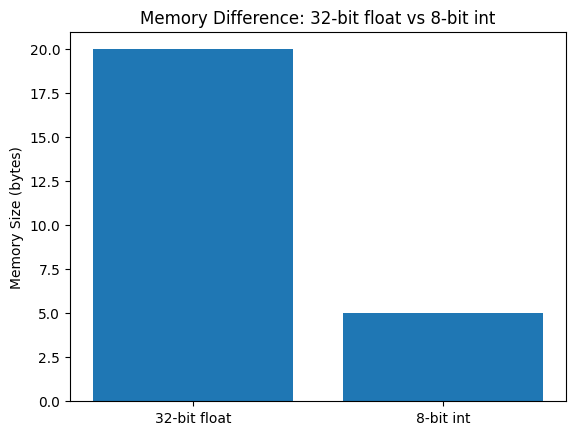

In [25]:
# Plot the memory difference
labels = ['32-bit float', '8-bit int']
memory_sizes = [float32_memory, int8_memory]

plt.bar(labels, memory_sizes)
plt.ylabel('Memory Size (bytes)')
plt.title('Memory Difference: 32-bit float vs 8-bit int')
plt.show()

Let's see what happens to this memory difference when we increase the size of the array.

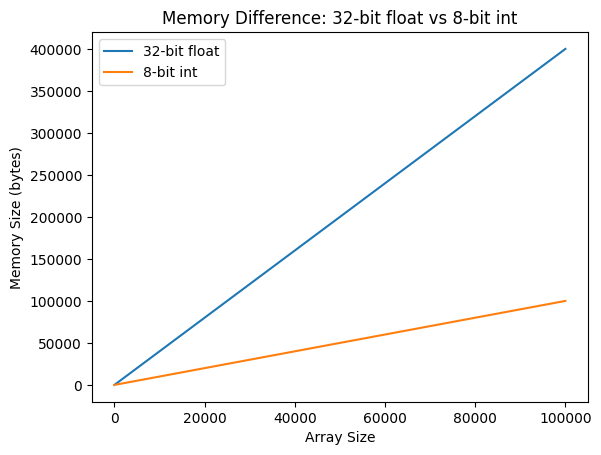

In [26]:
import matplotlib.pyplot as plt

# Array sizes to test
array_sizes = [10, 100, 1000, 10000, 100000]

# Initialize lists to store memory sizes
float32_memory_sizes = []
int8_memory_sizes = []

# Iterate over each array size
for size in array_sizes:
    # Create an array of numbers with the specified size
    numbers = np.random.rand(size)
    
    # Convert the numbers to 32-bit floating point
    float32_numbers = numbers.astype(np.float32)
    
    # Calculate the memory size of the float32 array
    float32_memory = float32_numbers.nbytes
    float32_memory_sizes.append(float32_memory)
    
    # Truncate the numbers to fit in 8-bit integer range and convert
    int8_numbers = numbers.astype(np.uint8)
    
    # Calculate the memory size of the int8 array
    int8_memory = int8_numbers.nbytes
    int8_memory_sizes.append(int8_memory)

# Plot the memory difference
plt.plot(array_sizes, float32_memory_sizes, label='32-bit float')
plt.plot(array_sizes, int8_memory_sizes, label='8-bit int')
plt.xlabel('Array Size')
plt.ylabel('Memory Size (bytes)')
plt.title('Memory Difference: 32-bit float vs 8-bit int')
plt.legend()
plt.show()

1. Linear Relationship: The memory size increases linearly with the array size for both data types. This is expected since memory usage is directly proportional to the number of elements in the array.

2. Memory Efficiency: The 8-bit integer representation is more memory-efficient than the 32-bit float. This is because 8-bit integers use 1/4th of the memory that 32-bit floats use per element.

3. Data Range and Precision: While 8-bit integers are more memory-efficient, they can only represent values between 0 to 255 (unsigned) or -128 to 127 (signed). In contrast, 32-bit floats can represent a much broader range of values, including decimal points, with higher precision.

4. Impact on Performance: Smaller data types can improve performance, not just in terms of memory usage, but also because they can reduce the time for data to be transferred between different parts of the computer (like CPU and RAM) and can sometimes take advantage of vectorized operations that process multiple data points in a single instruction.

Intuition for how difference in precision format affects LLM performance.

1. Inference Speed: Using 8-bit integers can lead to faster inference times. This is because smaller data types reduce the load on memory bandwidth and can be processed more quickly by the CPU or specialized hardware like FPGAs and TPUs that may have optimized pathways for low-precision arithmetic.

2. Batch Processing: With reduced memory footprint, it's possible to process larger batches of data at once. This can be particularly beneficial when serving LLMs in a cloud environment where throughput is critical.

3. Energy Efficiency: Lower precision computations can be more energy-efficient, which is not only beneficial for running models on edge devices but also for reducing the environmental impact of AI, given the large scale at which LLMs are often run.

4. Model Fine-Tuning: When fine-tuning LLMs, the use of lower precision formats can significantly reduce the memory requirements, allowing for fine-tuning larger models or using larger datasets on the same hardware.

5. Quantization Noise: The reduced precision of 8-bit integers introduces quantization noise. While LLMs can be robust to some noise, this may affect the quality of the model's output, possibly requiring retraining or fine-tuning to adapt to the lower precision.

6. Cache Utilization: Smaller data types improve cache utilization, as more data can fit into the CPU cache. This can reduce the number of cache misses and improve the overall speed of computations.

7. Accuracy and Range: Precision loss might lead to a reduction in the model's ability to discern between subtly different input tokens, potentially impacting the quality of the generated text. Also, the limited range of 8-bit integers means that gradient or weight values that are too small or too large might be clipped, leading to potential underflow or overflow issues during training.

8. Hardware Compatibility: Some hardware accelerators are optimized for 8-bit integers, which means that models using this precision might see performance gains on such hardware compared to using 32-bit floating-point numbers.

9. Algorithmic Stability: Certain algorithms within LLMs, such as softmax or attention mechanisms, might be sensitive to reduced precision. Careful consideration of algorithm stability is necessary when applying quantization.

10. Quantization-aware Training: To mitigate the effects of precision loss, models can be trained with quantization in mind, adjusting the training process to account for the reduced numeric range and resolution.

In practice you should use 4bit quantization as it is shown to have the best accuracy-trade off for [zero-shot performance as explained in this paper](https://arxiv.org/pdf/2212.09720.pdf).

Reasons to use 4-bit quantization:

Further investigation helped me understand the reasons why a quantized 4-bit model can outperform its base model:

Efficiency in Computation and Memory Usage: Quantization reduces the model size and speeds up inference by using lower-precision arithmetic. In some cases, this efficiency can lead to better performance if the original model was constrained by computational resources.
Regularization Effect: Quantization introduces a form of noise that can act as a regularizer, potentially improving generalization. This could lead to better performance on certain tasks where overfitting is a concern in the base model.
Hardware Optimization: Certain hardware is optimized for low-precision arithmetic, meaning a quantized model might run more efficiently and with less latency, which is crucial for real-time applications. This improved speed can indirectly contribute to better performance in tasks that benefit from rapid processing.
Specialized Scenarios: In some specialized tasks or datasets such as our RAG evaluation scenario for Paul Graham’s essay, the fine-grained details captured by a full-precision model may not be necessary, and a quantized model might capture the essential information just as well or even better.
Model Calibration: The process of quantizing a model involves calibrating it to the lower bit representation, which can sometimes lead to discovering more optimal weight configurations than those found in the original training.